In [46]:
#| label: code

#!pip install scikit-learn
#!pip install tensorflow 
#!pip install yfinance
#!pip install plotly
#!pip install statsmodels
#!pip install IPython
#!pip install matplotlib
#!pip install seaborn
#!pip install jupyter
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import yfinance as yf
import plotly.express as px
import statsmodels.api as sm 
from IPython.display import IFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.layers import Dense, SimpleRNN, LSTM, GRU


In [17]:
#|label: download-stock

# Pfizer
pfe = yf.download("PFE", '2019-01-01','2024-04-01')

# Teva
teva = yf.download("TEVA", '2019-01-01','2024-04-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
#|label: clean-stock

# Clean PFE
pfe = pfe.reset_index()
pfe = pfe.rename(columns={'Date':'t', 'Adj Close':'y'})
pfe = pfe[['t', 'y']]
t_pfe = np.array([*range(0,pfe.shape[0])])
x_pfe = np.array(pfe['y']).reshape(t_pfe.shape[0],1)
feature_columns_pfe = [0]
target_columns_pfe = [0]

# Clean TEVA
teva = teva.reset_index()
teva = teva.rename(columns={'Date':'t', 'Adj Close':'y'})
teva = teva[['t', 'y']]
t_teva = np.array([*range(0,teva.shape[0])])
x_teva = np.array(teva['y']).reshape(t_teva.shape[0],1)
feature_columns_teva = [0]
target_columns_teva = [0]

# 1. Original Data

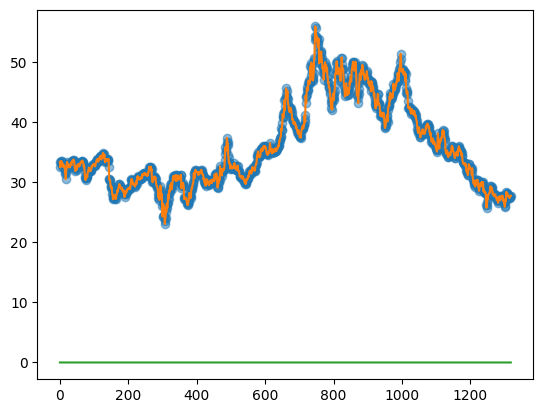

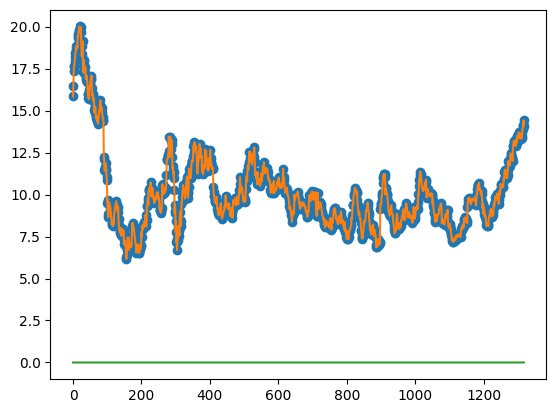

In [19]:
#| label: plot-original-pfe
#| fig-cap: Original Data
#| fig-subcap: 
#|   - "Original Data of PFE Stock"
#|   - "Original Data of TEVA Stock"
#| layout-ncol: 2

#print(type(t_pfe), type(x_pfe))
#print(t_pfe.shape, x_pfe.shape)

fig, ax = plt.subplots()
for i in range(0,x_pfe.shape[1]):
    ax.plot(t_pfe, x_pfe[:,i],'o',alpha = 0.5)
    ax.plot(t_pfe, x_pfe[:,i],"-")
ax.plot(t_pfe, 0*x_pfe[:,0],"-")
plt.show()

#x_teva=(x_teva-np.mean(x_teva,axis=0))/np.std(x_teva,axis=0)
#print(x_teva.shape)
fig, ax = plt.subplots()
for i in range(0,x_teva.shape[1]):
    ax.plot(t_teva, x_teva[:,i],'o')
    ax.plot(t_teva, x_teva[:,i],"-")
ax.plot(t_teva, 0*x_teva[:,0],"-") # add baseline for reference 
plt.show()

# 2. Fitting Neural Networks and Forecast

## 2.1 Data Preprossing

### Data Normalization

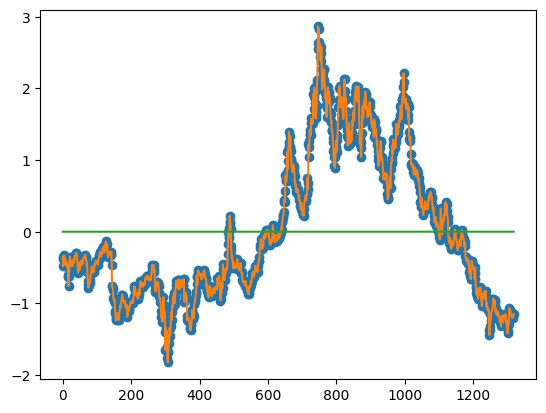

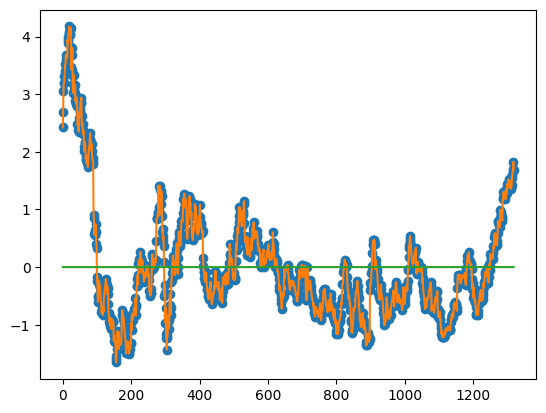

In [20]:
#|label: normalization-stock
#|fig-cap: Normalized Stock Data
#|fig-subcap:
#|  - "Normalized PFE Stock"
#|  - "Normalized TEVA Stock"
#| layout-ncol: 2


## Pfizer
#print(np.mean(x_pfe,axis=0).shape,np.std(x_pfe,axis=0).shape)
x_pfe=(x_pfe-np.mean(x_pfe,axis=0))/np.std(x_pfe,axis=0)
#print(x_pfe.shape)
fig, ax = plt.subplots()
for i in range(0,x_pfe.shape[1]):
    ax.plot(t_pfe, x_pfe[:,i],'o')
    ax.plot(t_pfe, x_pfe[:,i],"-")
ax.plot(t_pfe, 0*x_pfe[:,0],"-")
plt.show()

## TEVA
#print(np.mean(x_teva,axis=0).shape,np.std(x_teva,axis=0).shape)
x_teva=(x_teva-np.mean(x_teva,axis=0))/np.std(x_teva,axis=0)
#print(x_teva.shape)
fig, ax = plt.subplots()
for i in range(0,x_teva.shape[1]):
    ax.plot(t_teva, x_teva[:,i],'o')
    ax.plot(t_teva, x_teva[:,i],"-")
ax.plot(t_teva, 0*x_teva[:,0],"-")
plt.show()

### Data Splitting

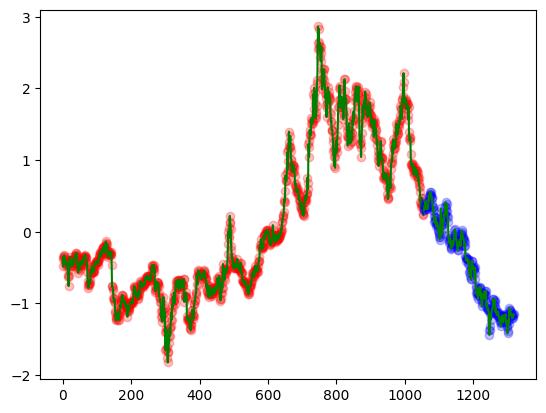

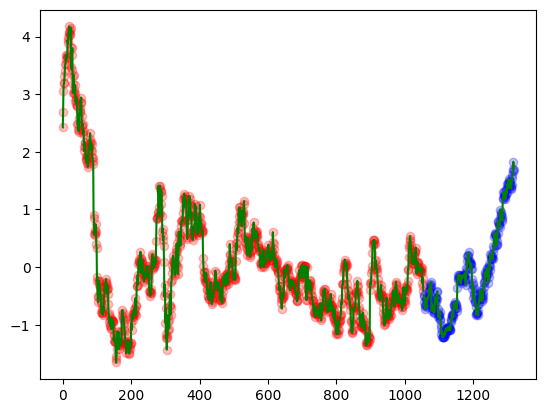

In [21]:
#| label: splitted-stock
#| fig-cap: Splitted Stock Data
#| fig-subcap:
#|  - "Splitted PFE Stock"
#|  - "Splitted TEVA Stock"
#| layout-ncol: 2

# Data Split
## PFE
split_fr = 0.8
cut=int(split_fr*x_pfe.shape[0])
tt_pfe=t_pfe[0:cut]; xt_pfe=x_pfe[0:cut]
tv_pfe=t_pfe[cut:]; xv_pfe=x_pfe[cut:]

fig, ax = plt.subplots()
for i in range(0,x_pfe.shape[1]):
    ax.plot(tt_pfe, xt_pfe[:,i],'ro',alpha=0.25)
    ax.plot(tt_pfe, xt_pfe[:,i],"g-")
for i in range(0,x_pfe.shape[1]):
    ax.plot(tv_pfe, xv_pfe[:,i],'bo',alpha=0.25)
    ax.plot(tv_pfe, xv_pfe[:,i],"g-")
plt.show()

## TEVA
split_fr = 0.8
cut=int(split_fr*x_teva.shape[0])
tt_teva=t_teva[0:cut]; xt_teva=x_teva[0:cut]
tv_teva=t_teva[cut:]; xv_teva=x_teva[cut:]

fig, ax = plt.subplots()
for i in range(0,x_teva.shape[1]):
    ax.plot(tt_teva, xt_teva[:,i],'ro',alpha=0.25)
    ax.plot(tt_teva, xt_teva[:,i],"g-")
for i in range(0,x_teva.shape[1]):
    ax.plot(tv_teva, xv_teva[:,i],'bo',alpha=0.25)
    ax.plot(tv_teva, xv_teva[:,i],"g-")
plt.show()

### Mini-Batching

In [22]:
#| label: mini-batching-function

def from_arrays(x, lookback=3, delay=1, step=1, feature_columns=[0], target_columns=[0], unique=False, verbose=False):
    # initialize 
    i_start = 0
    count = 0
    x_out = []
    y_out = []

    # sequentially build mini-batch samples
    while i_start + lookback + delay < x.shape[0]:
        i_stop = i_start + lookback
        i_pred = i_stop + delay

        # report if desired 
        #if verbose and count < 2: 
        #    print("indice range:", i_start, i_stop, "-->", i_pred)

        # define arrays: 
        indices_to_keep = []
        j = i_stop
        while j >= i_start:
            indices_to_keep.append(j)
            j -= step

        # create mini-batch sample
        xtmp = x[indices_to_keep, :]    # isolate relevant indices
        xtmp = xtmp[:, feature_columns] # isolate desired features
        ytmp = x[i_pred, target_columns]
        x_out.append(xtmp)
        y_out.append(ytmp)

        # report if desired 
        #if verbose and count < 2: 
        #    print(xtmp, "-->", ytmp)
        #    print("shape:", xtmp.shape, "-->", ytmp.shape)

        # Plot for debugging    
        if verbose and count < 2:
            fig, ax = plt.subplots()
            ax.plot(x, 'b-')
            ax.plot(x, 'bx')
            ax.plot(indices_to_keep, xtmp, 'go')
            ax.plot(i_pred * np.ones(len(target_columns)), ytmp, 'ro')
            plt.show()

        # Update start point 
        if unique:
            i_start += lookback
        else:
            i_start += 1
        count += 1

    return np.array(x_out), np.array(y_out)

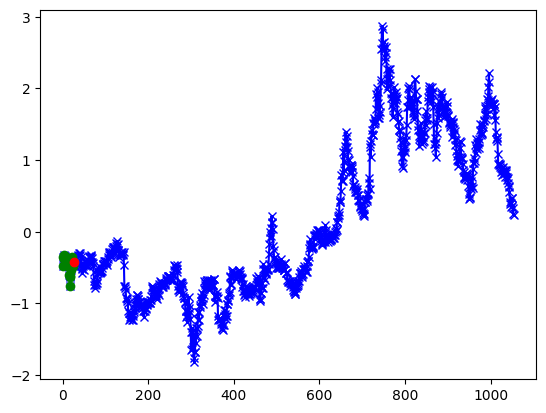

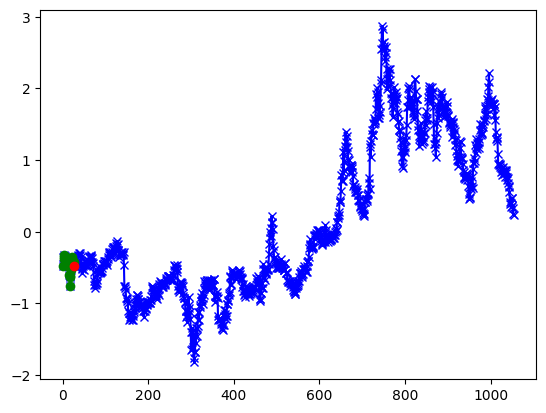

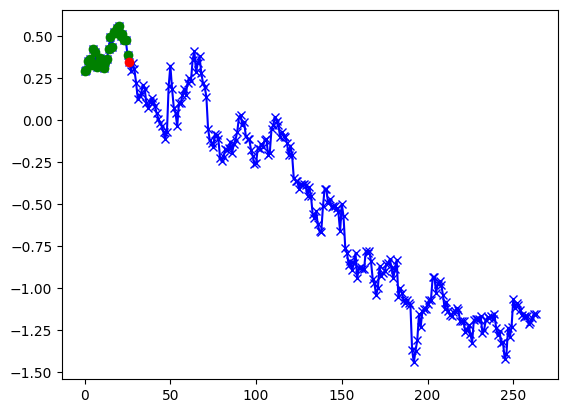

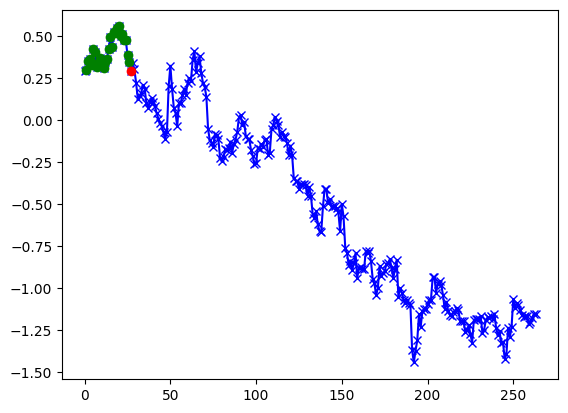

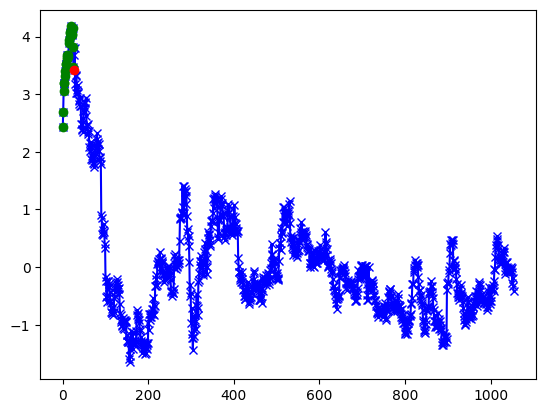

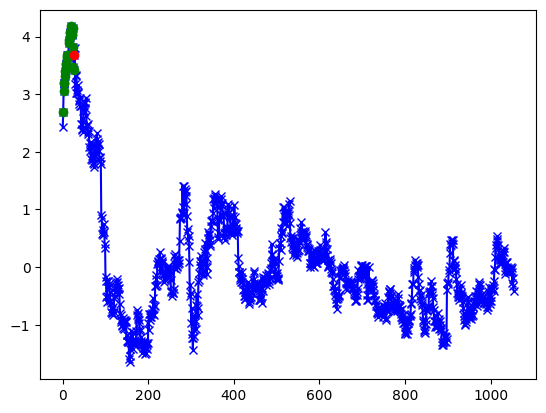

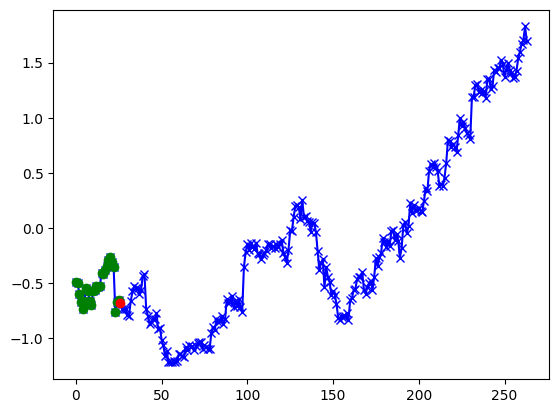

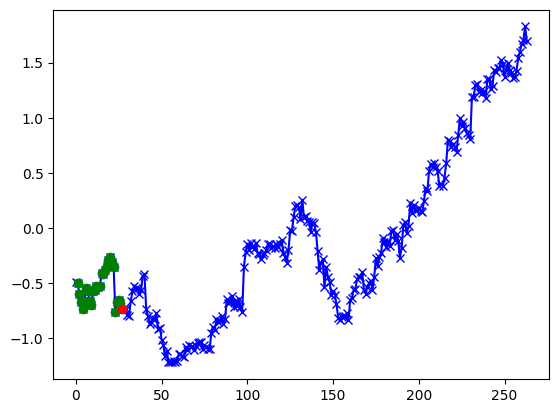

In [23]:
#| label: mini-batching-stock
#| fig-cap: Mini Batching Stock Data
#| fig-subcap:
#|  - "Mini-Batching PFE Stock"
#|  - "Mini-Batching PFE Stock"
#|  - "Mini-Batching PFE Stock"
#|  - "Mini-Batching PFE Stock"
#|  - "Mini-Batching TEVA Stock"
#|  - "Mini-Batching TEVA Stock"
#|  - "Mini-Batching TEVA Stock"
#|  - "Mini-Batching TEVA Stock"
#| layout-ncol: 4

# Mini-batch
## PFE
L=25; S=1; D=1

Xt_pfe, Yt_pfe = from_arrays(xt_pfe, lookback=L, delay=D, step=S, feature_columns=feature_columns_pfe, target_columns=target_columns_pfe, unique=False,verbose=True)
Xv_pfe, Yv_pfe = from_arrays(xv_pfe, lookback=L, delay=D, step=S, feature_columns=feature_columns_pfe, target_columns=target_columns_pfe, unique=False,verbose=True)
#print('Training:', Xt_pfe.shape, Yt_pfe.shape)
#print('Validation:', Xv_pfe.shape, Yv_pfe.shape)

## TEVA
L=25; S=1; D=1

Xt_teva, Yt_teva = from_arrays(xt_teva, lookback=L, delay=D, step=S, feature_columns=feature_columns_teva, target_columns=target_columns_teva, unique=False,verbose=True)
Xv_teva, Yv_teva = from_arrays(xv_teva, lookback=L, delay=D, step=S, feature_columns=feature_columns_teva, target_columns=target_columns_teva, unique=False,verbose=True)
#print('Training:', Xt_teva.shape, Yt_teva.shape)
#print('Validation:', Xv_teva.shape, Yv_teva.shape)

In [24]:
#| label: minibatching-train-validation

print('Training(PFE):', Xt_pfe.shape, Yt_pfe.shape)
print('Validation(PFE):', Xv_pfe.shape, Yv_pfe.shape)

print('Training(TEVA):', Xt_teva.shape, Yt_teva.shape)
print('Validation(TEVA):', Xv_teva.shape, Yv_teva.shape)

Training(PFE): (1029, 26, 1) (1029, 1)
Validation(PFE): (238, 26, 1) (238, 1)
Training(TEVA): (1029, 26, 1) (1029, 1)
Validation(TEVA): (238, 26, 1) (238, 1)


In [25]:
#|label: regression-report-function

def regression_report(yt,ytp,yv,yvp):
    print("---------- Regression report ----------")
    
    print("TRAINING:")
    print(" MSE:",mean_squared_error(yt,ytp))
    print(" MAE:",mean_absolute_error(yt,ytp))
    # print(" MAPE:",mean_absolute_percentage_error(Yt,Ytp))
    
    # PARITY PLOT
    fig, ax = plt.subplots()
    ax.plot(yt,ytp,'ro')
    ax.plot(yt,yt,'b-')
    ax.set(xlabel='y_data', ylabel='y_predicted',
        title='Training data parity plot (line y=x represents a perfect fit)')
    plt.show()
    
    # PLOT PART OF THE PREDICTED TIME-SERIES
    frac_plot=1.0
    upper=int(frac_plot*yt.shape[0]); 
    # print(int(0.5*yt.shape[0]))
    fig, ax = plt.subplots()
    ax.plot(yt[0:upper],'b-')
    ax.plot(ytp[0:upper],'r-',alpha=0.5)
    ax.plot(ytp[0:upper],'ro',alpha=0.25)
    ax.set(xlabel='index', ylabel='y(t) (blue=actual & red=prediction)', title='Training: Time-series prediction')
    plt.show()

      
    print("VALIDATION:")
    print(" MSE:",mean_squared_error(yv,yvp))
    print(" MAE:",mean_absolute_error(yv,yvp))
    # print(" MAPE:",mean_absolute_percentage_error(Yt,Ytp))
    
    # PARITY PLOT 
    fig, ax = plt.subplots()
    ax.plot(yv,yvp,'ro')
    ax.plot(yv,yv,'b-')
    ax.set(xlabel='y_data', ylabel='y_predicted',
        title='Validation data parity plot (line y=x represents a perfect fit)')
    plt.show()
    
    # PLOT PART OF THE PREDICTED TIME-SERIES
    upper=int(frac_plot*yv.shape[0])
    fig, ax = plt.subplots()
    ax.plot(yv[0:upper],'b-')
    ax.plot(yvp[0:upper],'r-',alpha=0.5)
    ax.plot(yvp[0:upper],'ro',alpha=0.25)
    ax.set(xlabel='index', ylabel='y(t) (blue=actual & red=prediction)', title='Validation: Time-series prediction')
    plt.show()

In [26]:
#| label: history-plot

## History Plot
def history_plot(history):
  FS=18 #fontsize

  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

## 2.2 RNN

### 2.2.1 PFE Stock

In [43]:
from tensorflow.keras.optimizers import RMSprop

(1029, 26, 1) --> (1029, 1)
(238, 26, 1) --> (238, 1)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_18 (SimpleRNN)       │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

None


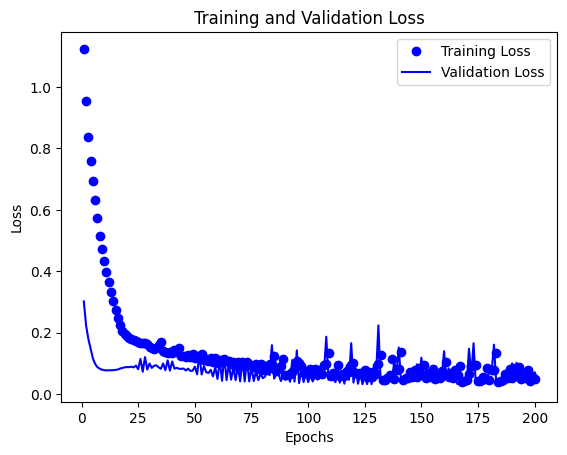

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
---------- Regression report ----------
TRAINING:
 MSE: 0.07868543630226066
 MAE: 0.2174210872852364


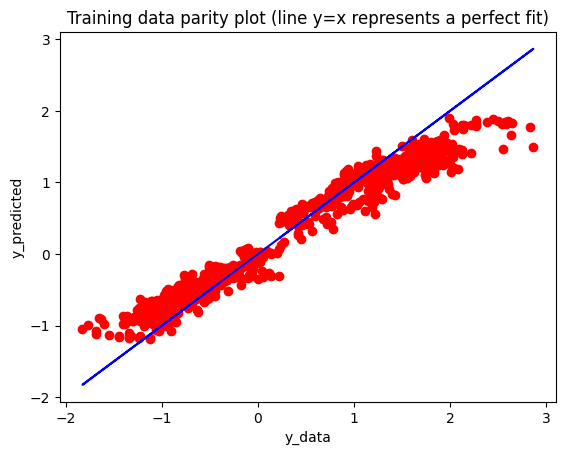

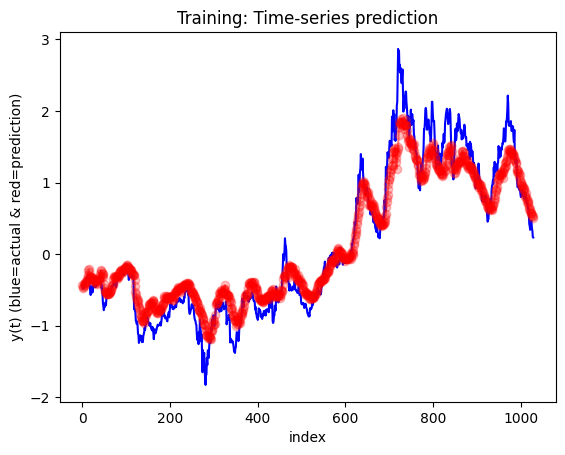

VALIDATION:
 MSE: 0.07048196317498322
 MAE: 0.22616758304423748


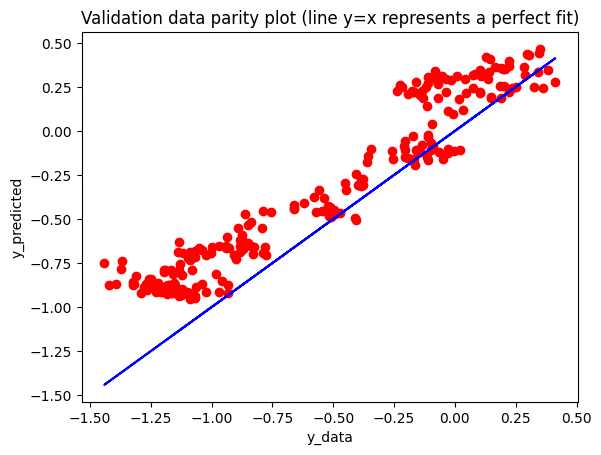

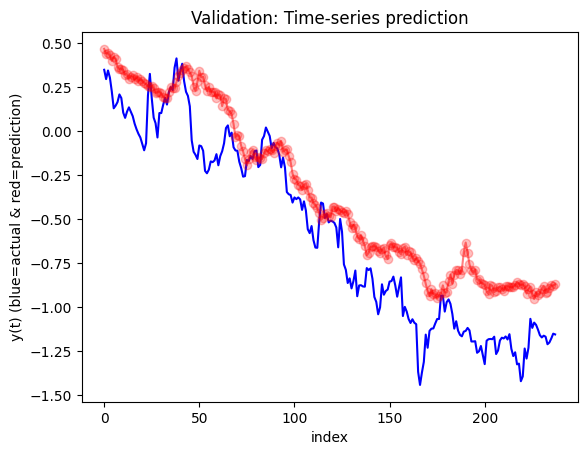

In [48]:
#| label: rnn-stock
#| layout-ncol: 2

## PFE
Xt1_pfe = Xt_pfe.reshape(Xt_pfe.shape[0],Xt_pfe.shape[1]*Xt_pfe.shape[2])
# New Sizes 
print(Xt_pfe.shape,"-->",Yt_pfe.shape)
print(Xv_pfe.shape,"-->",Yv_pfe.shape)
# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt_pfe.shape[1],Xt_pfe.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_pfe)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_pfe = model.fit(Xt_pfe,
                    Yt_pfe,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_pfe, Yv_pfe))
# History plot
history_plot(history_pfe)

# Predictions 
Ytp_pfe=model.predict(Xt_pfe)
Yvp_pfe=model.predict(Xv_pfe) 
# REPORT
regression_report(Yt_pfe,Ytp_pfe,Yv_pfe,Yvp_pfe)

## 2.3 GRU

### 2.3.1 PFE Stock

(1029, 26, 1) --> (1029, 1)
(238, 26, 1) --> (238, 1)


/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


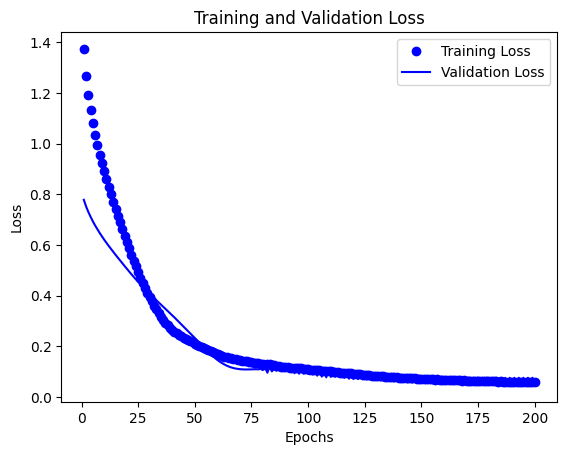

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
---------- Regression report ----------
TRAINING:
 MSE: 0.05850420179137441
 MAE: 0.18551930405122144


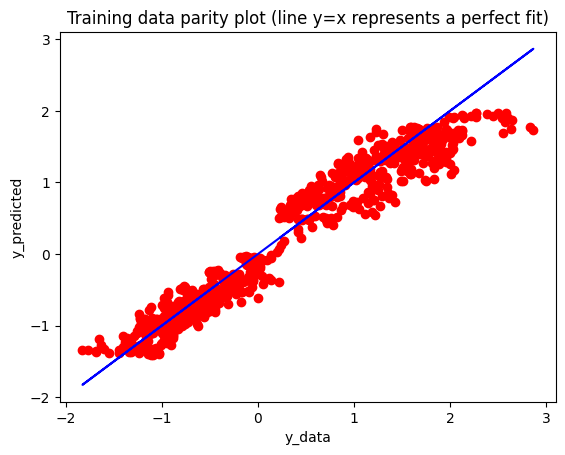

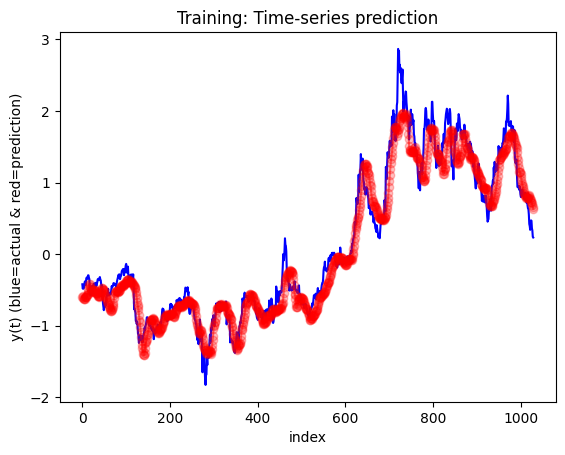

VALIDATION:
 MSE: 0.04768120792810544
 MAE: 0.1695625353082428


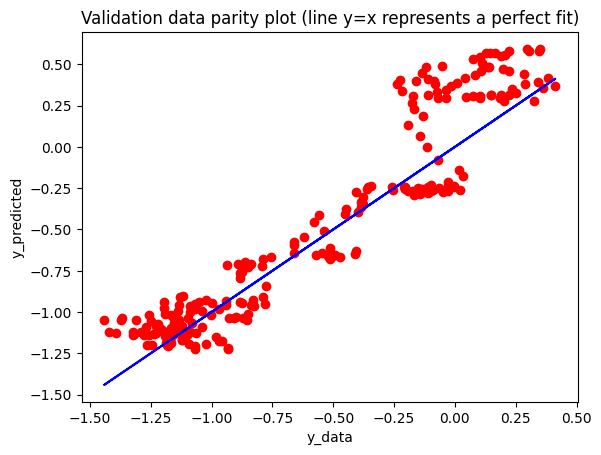

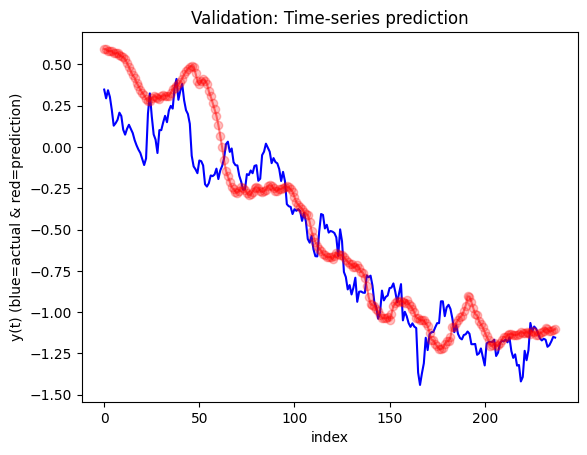

In [49]:
#| label: GRU-PFE-Stock
#| layout-ncol: 2

## PFE
Xt1_pfe = Xt_pfe.reshape(Xt_pfe.shape[0],Xt_pfe.shape[1]*Xt_pfe.shape[2])
# NEW SIZES 
print(Xt_pfe.shape,"-->",Yt_pfe.shape)
print(Xv_pfe.shape,"-->",Yv_pfe.shape)
# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt_pfe.shape[1],Xt_pfe.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_pfe)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_pfe = model.fit(Xt_pfe,
                    Yt_pfe,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_pfe, Yv_pfe))
# History plot
history_plot(history_pfe)

# Predictions 
Ytp_pfe=model.predict(Xt_pfe)
Yvp_pfe=model.predict(Xv_pfe) 
# REPORT
regression_report(Yt_pfe,Ytp_pfe,Yv_pfe,Yvp_pfe)

### 2.3.2 TEVA Stock

(1029, 26, 1) --> (1029, 1)
(238, 26, 1) --> (238, 1)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

None


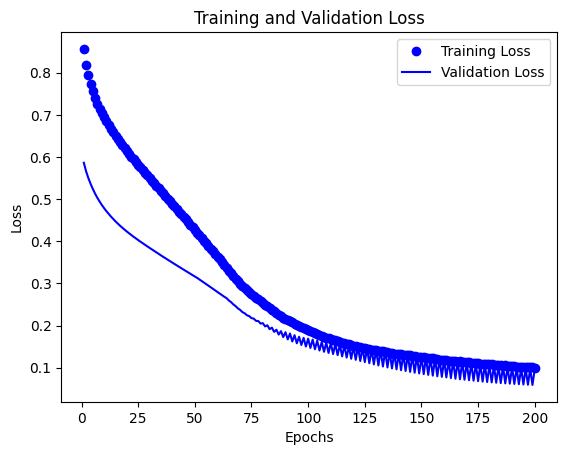

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.10032091183749599
 MAE: 0.2452942144927759


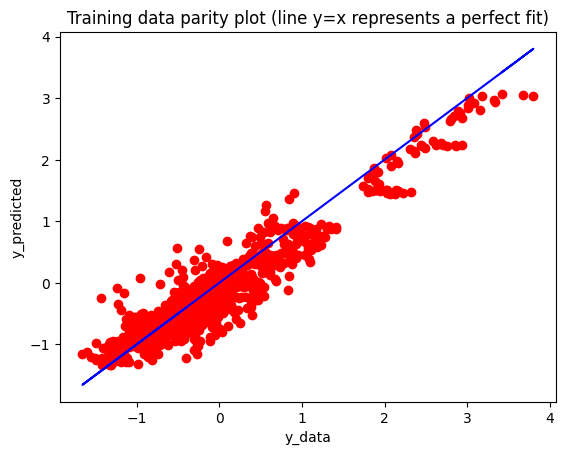

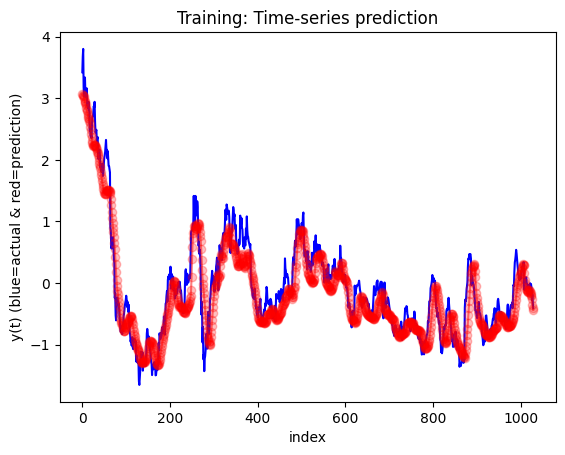

VALIDATION:
 MSE: 0.09667568289291516
 MAE: 0.25089988242170824


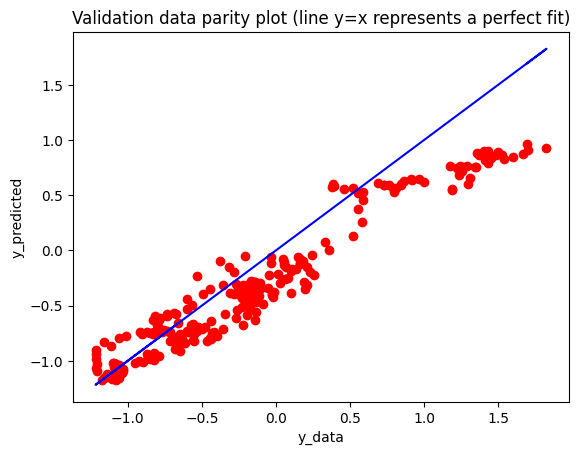

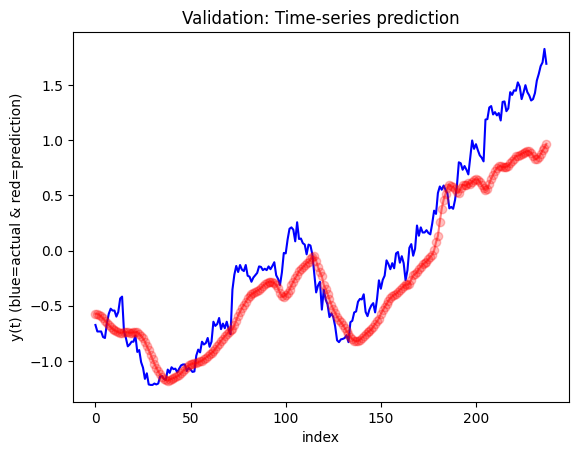

In [51]:
#| label: GRU-TEVA-Stock
#| layout-ncol: 2


## TEVA
Xt1_teva = Xt_teva.reshape(Xt_teva.shape[0],Xt_teva.shape[1]*Xt_teva.shape[2])
# NEW SIZES 
print(Xt_teva.shape,"-->",Yt_teva.shape)
print(Xv_teva.shape,"-->",Yv_teva.shape)
# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt_teva.shape[1],Xt_teva.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_teva)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)

# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_teva = model.fit(Xt_teva,
                    Yt_teva,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_teva, Yv_teva))
# History plot
history_plot(history_teva)

# Predictions 
Ytp_teva=model.predict(Xt_teva)
Yvp_teva=model.predict(Xv_teva) 
# REPORT
regression_report(Yt_teva,Ytp_teva,Yv_teva,Yvp_teva)

## 2.4 LSTM

### 2.4.1 LSTM on PFE

(1029, 26, 1) --> (1029, 1)
(238, 26, 1) --> (238, 1)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None


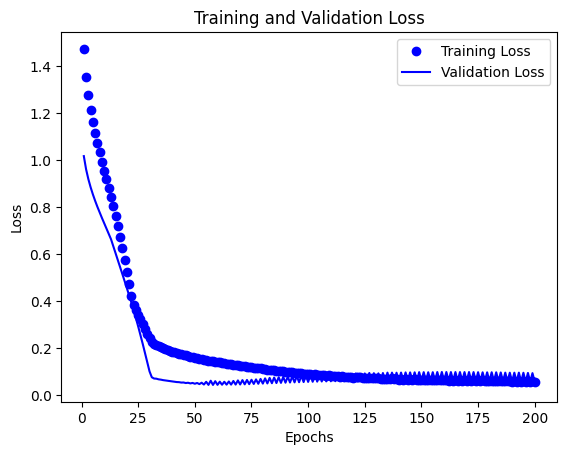

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.0584527757407153
 MAE: 0.18342063296844274


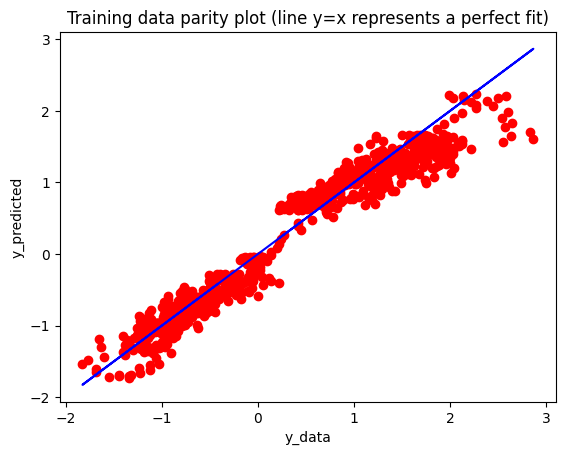

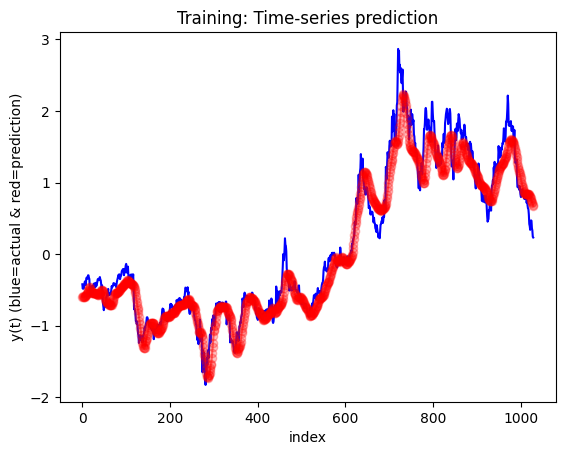

VALIDATION:
 MSE: 0.05558474461255623
 MAE: 0.17391328219232327


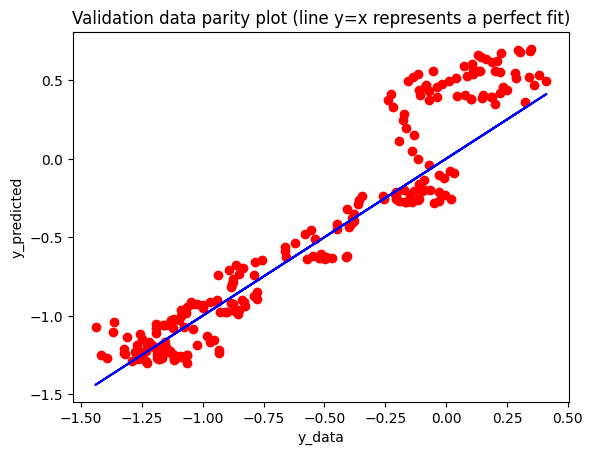

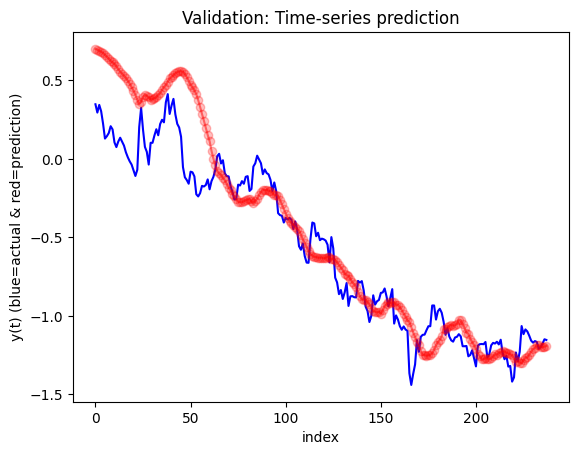

In [53]:
#| label: LSTM-PFE-Stock
# layout-ncol: 2

## PFE

Xt1_pfe = Xt_pfe.reshape(Xt_pfe.shape[0],Xt_pfe.shape[1]*Xt_pfe.shape[2])
# NEW SIZES 
print(Xt_pfe.shape,"-->",Yt_pfe.shape)
print(Xv_pfe.shape,"-->",Yv_pfe.shape)
# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt_pfe.shape[1],Xt_pfe.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_pfe)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)
# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_pfe = model.fit(Xt_pfe,
                    Yt_pfe,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_pfe, Yv_pfe))
# History plot
history_plot(history_pfe)
# Predictions 
Ytp_pfe=model.predict(Xt_pfe)
Yvp_pfe=model.predict(Xv_pfe) 
# REPORT
regression_report(Yt_pfe,Ytp_pfe,Yv_pfe,Yvp_pfe)

### 2.4.2 LSTM on TEVA

(1029, 26, 1) --> (1029, 1)
(238, 26, 1) --> (238, 1)


/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

None


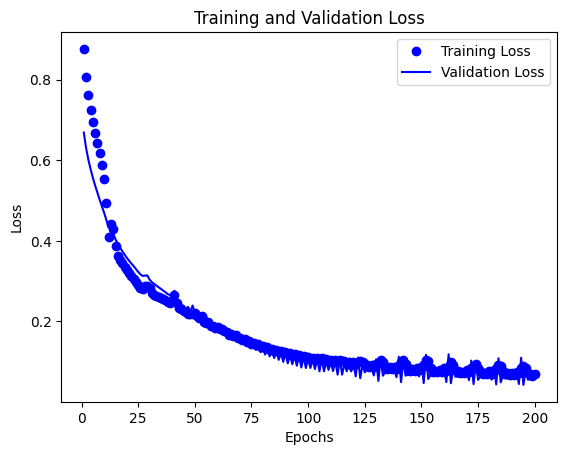

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.06525264216220746
 MAE: 0.19803091293188593


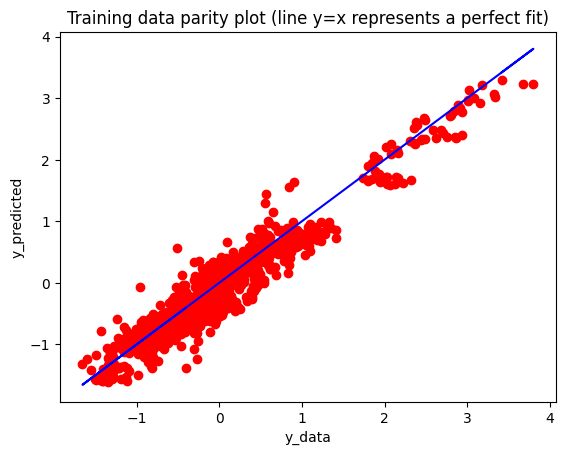

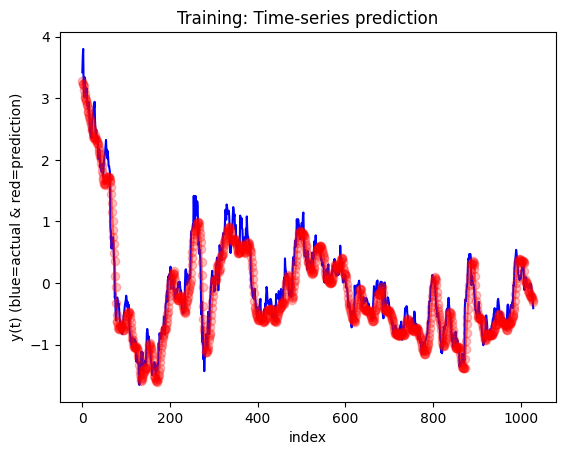

VALIDATION:
 MSE: 0.05693741030755657
 MAE: 0.19136522119965277


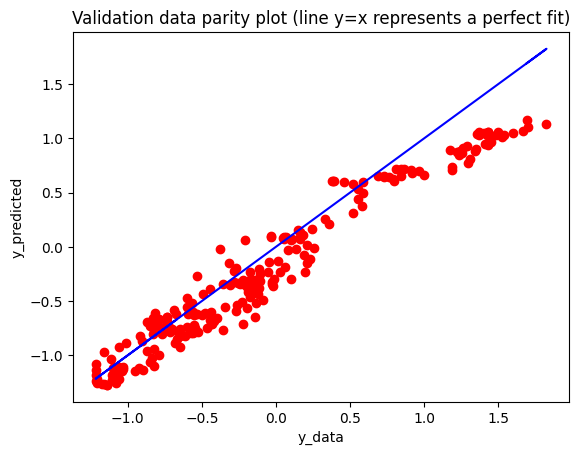

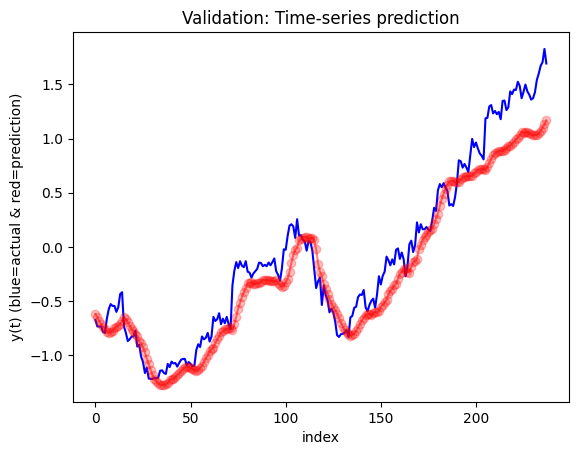

In [54]:
#| label: LSTM-TEVA-Stock
#| layout-ncol: 2

## TEVA

Xt1_teva = Xt_teva.reshape(Xt_teva.shape[0],Xt_teva.shape[1]*Xt_teva.shape[2])
# NEW SIZES 
print(Xt_teva.shape,"-->",Yt_teva.shape)
print(Xv_teva.shape,"-->",Yv_teva.shape)
# # HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt_teva.shape[1],Xt_teva.shape[2])

# # batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
batch_size=len(Xt1_teva)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
#model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)
# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history_teva = model.fit(Xt_teva,
                    Yt_teva,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv_teva, Yv_teva))
# History plot
history_plot(history_teva)
# Predictions 
Ytp_teva=model.predict(Xt_teva)
Yvp_teva=model.predict(Xv_teva) 
# REPORT
regression_report(Yt_teva,Ytp_teva,Yv_teva,Yvp_teva)

# 3 Discussion

## 3.1 How do the results from the 3 different ANN models compare with each other in terms of accuracy and predictive power?

**SIMPLE RNN**

———- Regression report ———-

TRAINING:

MSE: 0.19222594822669534

MAE: 0.15756450042939082

VALIDATION:

MSE: 0.05249601219423106

MAE: 0.1943597710946258

**GRU**

———- Regression report ———-

TRAINING:

MSE: 0.25952281290829476

MAE: 0.160723288559836

VALIDATION:

MSE: 0.03217333581016646

MAE: 0.13618835961067308

**LSTM**

———- Regression report ———-

TRAINING:

MSE: 0.2542570254310987

MAE: 0.16789481114153879

VALIDATION:

MSE: 0.03000315870773318

MAE: 0.12603178911548268

## 3.2 What effect does including regularization have on the results?

## 3.3 How far into the future can the deep learning model accurately predict the future?

## 3.4 How does your deep learning modeling compare to the traditional single-variable time-series ARMA/ARIMA models?

# 4 Comparision

## DEEP LEARNING PREDICTION Vs. Traditional TS Models